In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#----------------------------------------------

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser
from tqdm import tqdm

In [2]:
def standardization(X):
    return normalize(X, axis=0)

In [3]:
def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

In [4]:
def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

In [5]:
class Correlation_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'correlation')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [6]:
class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [7]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_all_news.csv')
df.head()

,Unnamed: 0,_id,topic,heading,content,tags,processed_content,processed_topic
0,0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal
1,1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal
2,2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal
3,3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal
4,4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal


In [15]:
from collections import Counter
Counter(df.topic[700:])

Counter({'["Business"]': 57,
         '["City"]': 22,
         '["DHNS"]': 1,
         '["Entertainment"]': 34,
         '["International"]': 27,
         '["Lifestyle"]': 36,
         '["Metrolife"]': 12,
         '["Nation"]': 109,
         '["National"]': 62,
         '["Opinion"]': 58,
         '["People"]': 1,
         '["Science and Environment"]': 17,
         '["Science"]': 3,
         '["Specials"]': 15,
         '["Spectrum"]': 2,
         '["Sports"]': 44,
         '["State"]': 31,
         '["Sunday Chronicle"]': 2,
         '["Sunday Herald"]': 1,
         '["Supplements"]': 5,
         '["Technology"]': 23,
         '["World"]': 42})

In [16]:
def read_NewsGroup_data(similarity):    
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    op = OptionParser()
    op.add_option("--lsa", dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")    
    op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing", action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features to extract from text.")    
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)
        
    labels = df.processed_topic[700:]
    #true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_features=opts.n_features,use_idf=opts.use_idf)
    X = vectorizer.fit_transform(df.processed_content[700:])
    if opts.n_components:
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [17]:
# Call Correlation_Similarity as similarity dataset.
trainSet_correlation = read_NewsGroup_data(Correlation_Similarity())

In [18]:
# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())

In [19]:
n_input = trainSet_correlation.data_size #--------- Number of input data.
print(n_input)
# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

604


In [20]:
n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_code = str(int(n_hidden_1/2)) #----------- The number of output dimension value.

In [21]:
print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', int(n_code))

Layer 1: ----------- 604
Layer 2: ----------- 512
Layer 3: ----------- 256


In [22]:
def k_means_(X, n_clusters):
    kmeans_centroids,_ =  kmeans(X, n_clusters)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [23]:
def encoder(x, n_code, mode_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("embedded"):
            code = layer(hidden_1, [n_hidden_1, n_code], [n_code], mode_train)
    return code

In [24]:
def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_1, [n_hidden_1, n_input], [n_input], mode_train)
    return output

In [25]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [26]:
def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [27]:
def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss

In [28]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [29]:
# Parameters
n_layers = 5 #----------------------------- Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------ The decay rate 1.  
beta2 = 0.999 #---------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #---------- The learning rate.
stop_learning = 1.35 #--------------------- The stop learning point.
n_batch = math.ceil(sqrt(sqrt(n_input))) #- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #--- Number of Backpro in per epoch.
n_clusters = 10 #--------------------------- Number of clusters.
n_diplay = 10 #---------------------------- Number of getting code and runnig the K-Means.

In [30]:
data_cor, labels_cor = trainSet_correlation.whole_dataset() #-- Allocation of data and labels
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels

In [31]:
results_cor=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cor=[] #------------------------- A list to keep all training evaluations.
seeding_cor=[] #--------------------------- A list to keep all steps.

In [32]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-07-18 09:14:52,309 WARNING From <ipython-input-26-5221a4ca5356>:4: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-07-18 09:14:52,329 WARNING From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
# Training cycle
epoch = 0
while epoch == 0 or new_cost >= stop_learning:
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_correlation.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train:True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or new_cost <= stop_learning:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cor = sess.run(code, feed_dict={x: data_cor, mode_train: False})        
        idx_cor = k_means_(ae_codes_cor, n_clusters)
        ae_nmi_cor = normalized_mutual_info_score(labels_cor, idx_cor)
        ae_nmi_cor = ae_nmi_cor*100
        results_cor.append(ae_nmi_cor)    
        steps_cor.append(epoch)
        loss_cost_cor.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cor, new_cost, epoch))

KeyError: ignored

In [ ]:
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
steps_cos=[] #----------------------------- A list to keep all steps.

In [34]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [35]:
# Training cycle
epoch = 0
while epoch == 0 or new_cost >= stop_learning:
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_cosine.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train: True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or new_cost <= stop_learning:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
        idx_cos = k_means_(ae_codes_cos, n_clusters)
        ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
        ae_nmi_cos = ae_nmi_cos*100
        results_cos.append(ae_nmi_cos)    
        steps_cos.append(epoch)
        loss_cost_cos.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cos, new_cost, epoch))

KeyError: ignored

NameError: ignored

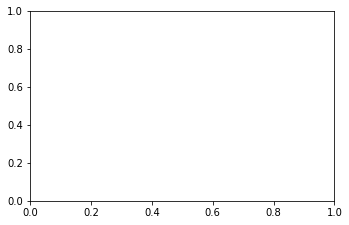

In [36]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
plt.plot(steps_cor, loss_cost_cor, label='Cost Trianing for Correlation Distance ', color='#000080', marker='o')
plt.plot(steps_cos, loss_cost_cos, label='Cost Trianing for Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost Function Trianing')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.ylim(1, 90)
plt.plot(steps_cor, results_cor, label='AE Normalized Correlation Distance ', color='#000080', marker='o')
plt.plot(steps_cos, results_cos, label='AE Normalized Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE Correlation is {:0.2f} \n and AE Cosine is {:0.2f}').format(ae_nmi_cor, ae_nmi_cos))
plt.legend(loc='best')
plt.show()

In [ ]:
origin_label_cos = np.array(trainSet_cosine.whole_dataset()[1]).astype(int)
origin_label_cor = np.array(trainSet_correlation.whole_dataset()[1]).astype(int)
colors = [('c', '1'),('g', '2'),('m','3')]
plt.figure(figsize=(14, 5))
for num in range(3):
    plt.subplot(1,2,1)
    plt.scatter([ae_codes_cor[:,0][i] for i in range(len(origin_label_cor)) if origin_label_cor[i] == num],
                [ae_codes_cor[:,1][i] for i in range(len(origin_label_cor)) if origin_label_cor[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title('Normalized Correlation Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title('Normalized Cosine Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

In [ ]:
colors = [('r', '1'),('b', '2'),('y','3')]
plt.figure(figsize=(14, 5))
for num in range(3):
    plt.subplot(1,2,1)
    plt.scatter([ae_codes_cor[:,0][i] for i in range(len(idx_cor)) if idx_cor[i] == num],
                [ae_codes_cor[:,1][i] for i in range(len(idx_cor)) if idx_cor[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title(('NMI of AE on Correlation is {:0.2f}').format(ae_nmi_cor))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title(('NMI of AE on Cosine is {:0.2f}').format(ae_nmi_cos))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

In [ ]:
print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(ae_nmi_cos))
print("Autoencoder Clustering on Correlation: ------- {:0.2f}".format(ae_nmi_cor))